# 05. Hybrid ANPR Pipeline (YOLO + Custom OCR)


In [7]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
from tensorflow.keras.models import load_model

## Cargamos el pipeline

In [8]:

detector = YOLO('../models/yolo_plate_detector.pt')
print('Loaded YOLOv8 detector')

ocr_model = load_model('../models/ocr_cnn.h5', compile=False)
print('Loaded custom OCR CNN')

class_names = sorted(os.listdir('../data/processed/train_ocr')) if os.path.exists('../data/processed/train_ocr') else []
print(f'OCR Classes ({len(class_names)}): {class_names}')

Loaded YOLOv8 detector
Loaded custom OCR CNN
OCR Classes (35): ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


## Segmentación de placas con YOLO

In [9]:
def find_candidates(thresh, h_plate, debug_img=None):
    """Find character candidates using contours and filtering."""
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    candidates = []
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        ratio = h / w
        
        if h > h_plate * 0.2 and h < h_plate * 0.95 and ratio > 0.1:
            candidates.append((x, y, w, h))
            if debug_img is not None:
                cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0, 255, 0), 1)
        else:
            if debug_img is not None:
                cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0, 0, 255), 1)
    
    return candidates

def segment_characters(plate_img, debug=False):
    """Segment characters from plate image."""
    h_plate, w_plate = plate_img.shape[:2]
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    
    thresh_adapt = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                         cv2.THRESH_BINARY_INV, 11, 2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thresh_adapt = cv2.morphologyEx(thresh_adapt, cv2.MORPH_CLOSE, kernel)
    
    candidates_adapt = find_candidates(thresh_adapt, h_plate)
    
    final_candidates = candidates_adapt
    method = "Adaptive"
    
    if len(candidates_adapt) < 4 or len(candidates_adapt) > 12:
        _, thresh_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        thresh_otsu = cv2.morphologyEx(thresh_otsu, cv2.MORPH_CLOSE, kernel)
        
        candidates_otsu = find_candidates(thresh_otsu, h_plate)
        
        if 4 <= len(candidates_otsu) <= 12:
            final_candidates = candidates_otsu
            method = "Otsu"
        elif len(candidates_otsu) > len(candidates_adapt) and len(candidates_adapt) < 4:
            final_candidates = candidates_otsu
            method = "Otsu"
        elif len(candidates_otsu) < len(candidates_adapt) and len(candidates_adapt) > 12:
            final_candidates = candidates_otsu
            method = "Otsu"
    
    if debug:
        print(f'  Segmentation: {method} method, {len(final_candidates)} candidates')
    
    bounding_boxes = sorted(final_candidates, key=lambda b: b[0])
    
    char_rois = []
    for (x, y, w, h) in bounding_boxes:
        roi = gray[y:y+h, x:x+w]
        roi = cv2.resize(roi, (32, 32))
        char_rois.append(roi)
    
    return char_rois

## Pipeline YOLO + Hybrid

In [10]:
def predict_plate_hybrid(image_path):
    img = cv2.imread(image_path)
    if img is None: return None
    
    h_img, w_img = img.shape[:2]
    
    results = detector(img, conf=0.05, verbose=False)
    
    if len(results[0].boxes) == 0:
        print(f"No plate detected in {os.path.basename(image_path)}")
        return None

    best_box = None
    max_conf = 0
    
    for box in results[0].boxes:
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
        conf = float(box.conf[0].cpu().numpy())
        
        w_box = x2 - x1
        h_box = y2 - y1
        
        if h_box > w_box: continue 
        if w_box < 40: continue 
        
        if conf > max_conf:
            max_conf = conf
            best_box = (x1, y1, x2, y2)
            
    if best_box is None: 
        print(f"Solo se detectó ruido en {os.path.basename(image_path)}")
        return None

    x1, y1, x2, y2 = best_box
    x1, y1 = max(0, x1-2), max(0, y1-2)
    x2, y2 = min(w_img, x2+2), min(h_img, y2+2)
    
    plate_crop = img[y1:y2, x1:x2]
    
    gray = cv2.cvtColor(plate_crop, cv2.COLOR_BGR2GRAY)
    
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 11, 2)
    
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    char_crops = []
    plate_h = plate_crop.shape[0]
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        
        if h < plate_h * 0.35: continue
        if h > plate_h * 0.98: continue
        
        char_crops.append((x, y, w, h))
    
    char_crops.sort(key=lambda b: b[0])
    
    raw_text = ""
    
    for x, y, w, h in char_crops:
        char_roi = gray[y:y+h, x:x+w] 
        
        input_char = cv2.resize(char_roi, (32, 32))
        input_char = input_char.astype('float32') / 255.0
        input_char = np.expand_dims(input_char, axis=-1)
        input_char = np.expand_dims(input_char, axis=0)
        
        probs = ocr_model.predict(input_char, verbose=0)
        idx = np.argmax(probs)
        char = class_names[idx]
        raw_text += char
        
    final_text = raw_text
    if len(final_text) > 3:
        if final_text.startswith("II"):
            final_text = final_text[2:]
        elif final_text.startswith("I") and final_text[1].isdigit(): 
            final_text = final_text[1:]

    print(f"[{os.path.basename(image_path)}] Detectado: {final_text}")
    
    plt.figure(figsize=(6, 3))
    plt.imshow(cv2.cvtColor(plate_crop, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicción: {final_text}")
    plt.axis('off')
    plt.show()
    
    return final_text

## Ejemplos

No plate detected in images10.jpg
[images100.jpg] Detectado: 1I0940


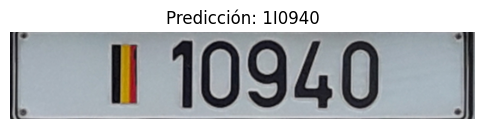

[images101.jpg] Detectado: I


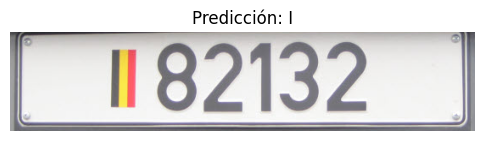

[images102.jpg] Detectado: I38648


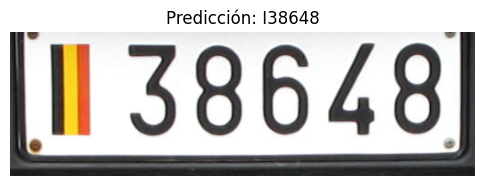

[images103.jpg] Detectado: 10955


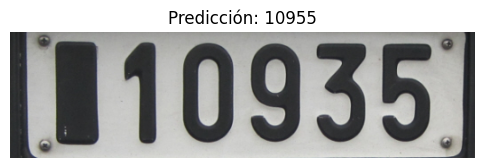


SUMMARY
images10.jpg                   → ---
images100.jpg                  → 1I0940
images101.jpg                  → I
images102.jpg                  → I38648
images103.jpg                  → 10955


In [11]:
import os

TEST_DIR = '../data/processed/test_samples'

if os.path.exists(TEST_DIR):
    test_images = [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR) if f.endswith(('.jpg', '.png', '.jpeg'))][:5]
    
    results = []
    for img_path in test_images:
        result = predict_plate_hybrid(img_path)
        results.append((os.path.basename(img_path), result))
    
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    for img_name, text in results:
        display_text = text if text else "---"
        print(f"{img_name:30s} → {display_text}")
else:
    print(f"Test directory not found: {TEST_DIR}")

Iniciando prueba rápida con 9 imágenes (de un total de 190)...

No plate detected in images10.jpg
[images100.jpg] Detectado: 1I0940


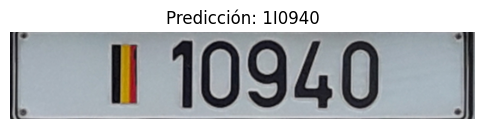

[images101.jpg] Detectado: I


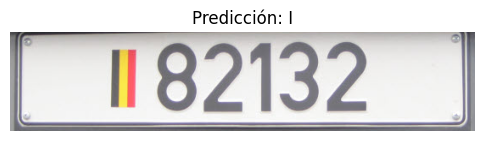

[images102.jpg] Detectado: I38648


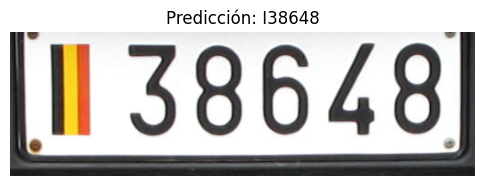

[images103.jpg] Detectado: 10955


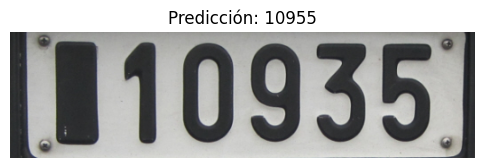

[images104.jpg] Detectado: IR78700I


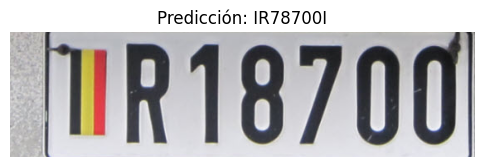

[images105.jpg] Detectado: IIR19DA


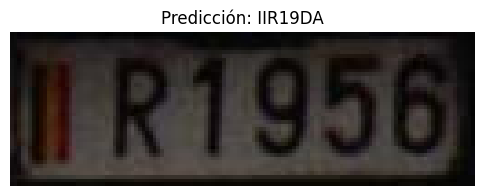

[images106.jpg] Detectado: I


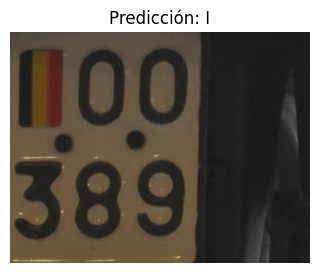

Solo se detectó ruido en images107.jpg

       RESUMEN FINAL


,Archivo,Placa Detectada
0,images10.jpg,---
1,images100.jpg,1I0940
2,images101.jpg,I
3,images102.jpg,I38648
4,images103.jpg,10955
5,images104.jpg,IR78700I
6,images105.jpg,IIR19DA
7,images106.jpg,I
8,images107.jpg,---


In [12]:
import glob
import pandas as pd

TEST_DIR = '../data/processed/test_samples'
extensions = ['*.jpg', '*.jpeg', '*.png']
test_images = []

for ext in extensions:
    test_images.extend(glob.glob(os.path.join(TEST_DIR, ext)))
test_images.sort()

test_sample = test_images[:9] 

print(f"Iniciando prueba rápida con {len(test_sample)} imágenes (de un total de {len(test_images)})...\n")

summary = []

for img_path in test_sample:
    try:
        result = predict_plate_hybrid(img_path) 
        
        summary.append({
            "Archivo": os.path.basename(img_path),
            "Placa Detectada": result if result else "---"
        })
    except Exception as e:
        print(f"Error en {img_path}: {e}")

print("\n" + "="*40)
print("       RESUMEN FINAL")
print("="*40)
df_final = pd.DataFrame(summary)
from IPython.display import display
display(df_final)